# Alignment using STAR

To determine where on the human genome our reads originated from, we will align our reads to the reference genome using STAR (Spliced Transcripts Alignment to a Reference). STAR is an aligner designed to specifically address many of the challenges of RNA-seq data mapping using a strategy to account for spliced alignments.

In [37]:
# set the path where to ouput files
%env outpath=/mnt/data/GeneExpression/output/RNASeq/ASTRO_DUMMY/STAR
%env path=/mnt/data/GeneExpression/input/RNASeq

env: outpath=/mnt/data/GeneExpression/output/RNASeq
env: path=/mnt/data/GeneExpression/input/RNASeq


## Reference genomes and annotation
Irrespective of the type of read mapping (alignment- or pseudoalignment), the presence of a reference sequence as well as gene annotation (i.e., which parts of the reference sequence correspond to genes) are fundamental to the majority of RNA-seq projects.

### Download reference genome 

In [7]:
%%bash
## it is already downloaded to $path - no need to rerun this cell
wget -P $path ftp://ftp.ensembl.org/pub/release-94/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz 


--2020-10-07 17:09:07--  ftp://ftp.ensembl.org/pub/release-94/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz
           => '/mnt/data/GeneExpression/input/RNASeq/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz'
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.197.76
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.197.76|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/fasta/homo_sapiens/dna ... done.
==> SIZE Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz ... 881214344
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz ... done.
Length: 881214344 (840M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  561K 25m35s
    50K .......... .......... .......... .......... ..........  0% 1.05M 19m27s
   100K .......... .......... .......... .......... ..........  0% 10.6M 13m24s
   150K .......... ...

In [9]:
%%bash
gunzip $path/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz

### Download annotation file

In [10]:
%%bash
wget -P $path ftp://ftp.ensembl.org/pub/release-94/gtf/homo_sapiens/Homo_sapiens.GRCh38.94.gtf.gz

--2020-10-07 17:14:55--  ftp://ftp.ensembl.org/pub/release-94/gtf/homo_sapiens/Homo_sapiens.GRCh38.94.gtf.gz
           => '/mnt/data/GeneExpression/input/RNASeq/Homo_sapiens.GRCh38.94.gtf.gz'
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.197.76
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.197.76|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-94/gtf/homo_sapiens ... done.
==> SIZE Homo_sapiens.GRCh38.94.gtf.gz ... 43652979
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.94.gtf.gz ... done.
Length: 43652979 (42M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  491K 87s
    50K .......... .......... .......... .......... ..........  0% 1013K 64s
   100K .......... .......... .......... .......... ..........  0% 11.5M 44s
   150K .......... .......... .......... .......... ..........  0% 11.3M 34s
   200K .......... .......... .......

In [25]:
%%bash
gunzip $path/Homo_sapiens.GRCh38.94.gtf.gz

## Align reads using STAR

###  Generate genome index 
Done only once per genome type (and alignment program). The index files will contain all the information from the reference genome in a compressed format that is optimized for efficient access and comparison with the query read sequences.

**note for me:** 1) nthreads variable does not work if outside the same cell. 2) Look into why the Log.out cannot be copied to mnt. 3) test that once STAR is installed from Dockerfile, STAR is on the PATH

In [27]:
%%bash 
nthreads=$(grep -c ^processor /proc/cpuinfo)
STAR --runMode genomeGenerate --genomeDir $path/STARindex --genomeFastaFiles $path/Homo_sapiens.GRCh38.dna.primary_assembly.fa --sjdbGTFfile $path/Homo_sapiens.GRCh38.94.gtf --sjdbOverhang 100 --runThreadN $nthreads-1

Oct 08 12:36:36 ..... started STAR run
Oct 08 12:36:36 ... starting to generate Genome files
Oct 08 12:37:12 ..... processing annotations GTF
Oct 08 12:37:32 ... starting to sort Suffix Array. This may take a long time...
Oct 08 12:37:44 ... sorting Suffix Array chunks and saving them to disk...
Oct 08 13:24:37 ... loading chunks from disk, packing SA...
Oct 08 13:37:43 ... finished generating suffix array
Oct 08 13:37:43 ... generating Suffix Array index
Oct 08 13:41:00 ... completed Suffix Array index
Oct 08 13:41:02 ..... inserting junctions into the genome indices
Oct 08 13:46:13 ... writing Genome to disk ...
Oct 08 13:47:19 ... writing Suffix Array to disk ...
Oct 08 13:52:21 ... writing SAindex to disk
Oct 08 13:52:38 ..... finished successfully


!!!!! WARNING: Could not move Log.out file from ./Log.out into /mnt/data/GeneExpression/input/RNASeq/STARindex/Log.out. Will keep ./Log.out



### Alignment 
This is the step that actually matches every read to the reference sequence, using the additional information about splice junctions etc. The alignment step therefore has to be completed for every individual FASTQ file.

For our analysis, each sample is done in 4 lanes, so 4 fasta files at a time are combined in STAR

**If using new data, paired-end -> combine 2 fasta**

In [40]:
%%bash
nthreads=$(grep -c ^processor /proc/cpuinfo)
for sample in S10 S27 S28 S29 S30 S31 S32 S33 S35 S36 S37 S38 S39 S40
do
  files=$(find "$path/FASTAQ" -maxdepth 1 -name "*$sample*" -print | paste -sd,)
  #echo "$files"
  mkdir -p "$outpath/$sample"
  cd "$outpath/$sample"
  STAR --genomeDir $path/STARindex --readFilesIn "$files" --readFilesCommand zcat --outFileNamePrefix "$sample" --outFilterMultimapNmax 1 --outReadsUnmapped Fastx --outSAMtype BAM SortedByCoordinate --twopassMode Basic --quantMode GeneCounts --runThreadN $nthreads-1
  cd ../
done

Oct 10 11:46:34 ..... started STAR run
Oct 10 11:46:34 ..... loading genome
Oct 10 11:52:25 ..... started 1st pass mapping
Oct 10 11:53:18 ..... finished 1st pass mapping
Oct 10 11:53:18 ..... inserting junctions into the genome indices
Oct 10 12:30:34 ..... started mapping
Oct 10 13:06:03 ..... finished mapping
Oct 10 13:06:09 ..... started sorting BAM
Oct 10 13:07:48 ..... finished successfully
Oct 10 13:07:51 ..... started STAR run
Oct 10 13:07:52 ..... loading genome
Oct 10 13:14:19 ..... started 1st pass mapping
Oct 10 13:15:18 ..... finished 1st pass mapping
Oct 10 13:15:19 ..... inserting junctions into the genome indices
Oct 10 14:01:40 ..... started mapping
Oct 10 14:31:04 ..... finished mapping
Oct 10 14:31:11 ..... started sorting BAM
Oct 10 14:33:14 ..... finished successfully
Oct 10 14:33:18 ..... started STAR run
Oct 10 14:33:19 ..... loading genome
Oct 10 14:39:36 ..... started 1st pass mapping
Oct 10 14:40:34 ..... finished 1st pass mapping
Oct 10 14:40:34 ..... inserti

### Quality control of aligned reads  
- look at Log.final.out file, it contains alignment statistics. An alignment of RNA-seq reads is usually considered to have succeeded if the mapping rate (uniquely mapped reads) is >70%



In [44]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [62]:
%%R
source("scripts/QCplotsSTAR.R")

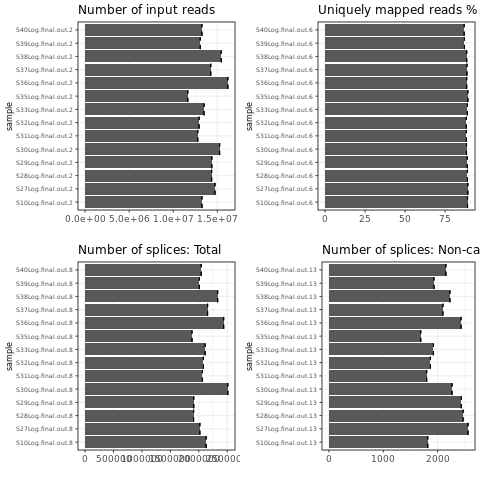

In [63]:
%%R
#This function takes Log.final.out from STAR output and generates QC plots
PlottingAlignmentResultsMain("/mnt/data/GeneExpression/output/RNASeq")

**Good quality of aligned reads.**

### Read Quantification. Gene-based read counting

Gene expression is quantified by counting the number of reads that mapped to each locus in the transcriptome assembly step. This quantification is done as the same time as the assembly, in step 1.2.2, by adding to the STAR command the parameter --quantMode GeneCounts.

Other popular tools for gene quantification are htseq-count and featureCounts. The 2nd column of the START result file (ReadsPerGene.out.tab) coincide with result from htseq-count. 


In [65]:
%%bash
head $outpath/S10/S10ReadsPerGene.out.tab

N_unmapped	1452127	1452127	1452127
N_multimapping	0	0	0
N_noFeature	328468	11423972	360632
N_ambiguous	603146	7359	255083
ENSG00000223972	0	0	0
ENSG00000227232	1	0	1
ENSG00000278267	0	0	0
ENSG00000243485	0	0	0
ENSG00000284332	0	0	0
ENSG00000237613	0	0	0


**For the next step, ReadQuantification to DESeqDataSet, you need the following:**
- ReadsPerGene.out.tab files

===== Session Info =======

In [66]:
%%R 
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
[1] C

attached base packages:
[1] grid      tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] gridExtra_2.3 ggplot2_3.3.2 knitr_1.30   

loaded via a namespace (and not attached):
 [1] digest_0.6.25    withr_2.2.0      dplyr_1.0.2      crayon_1.3.4    
 [5] R6_2.4.1         lifecycle_0.2.0  gtable_0.3.0     magrittr_1.5    
 [9] scales_1.1.1     pillar_1.4.6     rlang_0.4.7      farver_2.0.3    
[13] generics_0.0.2   vctrs_0.3.2      ellipsis_0.3.1   labeling_0.3    
[17] glue_1.4.1       purrr_0.3.4      munsell_0.5.0    xfun_0.18       
[21] compiler_4.0.2   pkgconfig_2.0.3  colorspace_1.4-1 tidyselect_1.1.0
[25] tibble_3.0.3    
